In [2]:
import sys
import os

thesis_path = "/" + os.path.join(
    *os.getcwd().split(os.path.sep)[:-1])
sys.path.append(thesis_path)


In [2]:
from evaluations.performance_01 import get_per_sample_metrics
from evaluations.utils import get_correct_latex_format
metrics_df = get_per_sample_metrics()

/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/loebbert/miniconda3/envs/haystack/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6c76f1b460>
  self.pid = os.fork()
/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/loebbert/miniconda3/envs/haystack/lib/python3.10/multiprocessing/popen_fork.py:66: ResourceWarning: unclosed sock

In [3]:
metrics_df.head()

,seed,model,checkpoint,dataset,doc_id,targets,entity_type,tp,fn,fp,error_type1,error_type2,error_type3,error_type4,error_type5
0,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,location,0,0,0,0,0,0,0,0
1,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,group,0,0,0,0,0,0,0,0
2,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,corporation,0,0,0,0,0,0,0,0
3,2,t5_asp_sent,last,lowner_test,lowner_test_0,2,person,2,0,0,0,0,0,0,0
4,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,creative-work,0,0,0,0,0,0,0,0


In [4]:
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30875400 entries, 0 to 30875399
Data columns (total 15 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   seed         object
 1   model        object
 2   checkpoint   object
 3   dataset      object
 4   doc_id       object
 5   targets      int64 
 6   entity_type  object
 7   tp           int64 
 8   fn           int64 
 9   fp           int64 
 10  error_type1  int64 
 11  error_type2  int64 
 12  error_type3  int64 
 13  error_type4  int64 
 14  error_type5  int64 
dtypes: int64(9), object(6)
memory usage: 3.5+ GB


In [5]:
metrics_df.describe()

,targets,tp,fn,fp,error_type1,error_type2,error_type3,error_type4,error_type5
count,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07,3.087540e+07
mean,2.161282e-01,1.462266e-01,6.990154e-02,2.636537e-01,2.366940e-01,4.699852e-02,5.773723e-03,1.037337e-02,1.091516e-02
std,5.983969e-01,4.874700e-01,3.165672e-01,8.694029e-01,8.375496e-01,2.641294e-01,7.894163e-02,1.105230e-01,1.179668e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.200000e+01,1.200000e+01,1.200000e+01,2.300000e+01,2.300000e+01,1.200000e+01,7.000000e+00,7.000000e+00,1.100000e+01


# Model performance
## Micro-F1 + 5 Error Types avg+std

In [6]:
# Micro - F1
from evaluations.performance_01 import get_micro_f1_precision_recall
result = get_micro_f1_precision_recall(metrics_df, "last", "lowner_test")
result

model checkpoint      dataset         f1            \
                                                               mean       std   
4                 dict_match_gaz       last  lowner_test  28.573637  0.007001   
10           dict_match_gaz_sent       last  lowner_test  29.404060  0.045085   
16          dict_match_lownergaz       last  lowner_test  20.773579  0.019751   
22     dict_match_lownergaz_sent       last  lowner_test  21.611711  0.012736   
28               dict_match_sent       last  lowner_test  29.028146  0.009593   
34                 flair_roberta       last  lowner_test  84.064658  0.110460   
40              search_match_gaz       last  lowner_test  37.168811  0.018344   
46         search_match_gaz_sent       last  lowner_test  43.190684  0.019899   
52        search_match_lownergaz       last  lowner_test  50.239811  0.038783   
58   search_match_lownergaz_sent       last  lowner_test  59.462562  0.010283   
64             search_match_sent       last  lowner_test  37.187504  0.004034   
70                        t5_asp       last  lowner_test  85.481521  0.163211   
76                    t5_asp_gaz       last  lowner_test  86.515093  1.373751   
82               t5_asp_gaz_sent       last  lowner_test  88.478024  0.122478   
88              t5_asp_lownergaz       last  lowner_test  87.478254  2.444407   
94         t5_asp_lownergaz_sent       last  lowner_test  89.600103  0.029477   
100                  t5_asp_sent       last  lowner_test  86.724683  0.218033   

     precision               recall            
          mean       std       mean       std  
4    20.357842  0.004988  47.907707  0.011738  
10   20.949493  0.032122  49.300027  0.075591  
16   11.898689  0.011313  81.744289  0.077719  
22   12.376276  0.007294  85.159514  0.050186  
28   20.691513  0.006838  48.615305  0.016067  
34   82.972975  0.316572  85.186202  0.112832  
40   35.845302  0.017691  38.593802  0.019047  
46   43.988235  0.020266  42.421539  0.019544  
52   44.945538  0.034696  56.947876  0.043961  
58   59.281405  0.010252  59.644829  0.010315  
64   78.635446  0.008529  24.351877  0.002641  
70   86.982432  0.295482  84.031781  0.061052  
76   88.825027  0.325854  84.359655  2.830382  
82   89.540748  0.150150  87.440906  0.310630  
88   90.383760  0.077121  84.831641  4.507486  
94   90.848639  0.268918  88.386403  0.255862  
100  88.775777  0.208632  84.766828  0.357262

In [7]:
print(get_correct_latex_format(result, ["f1", "precision", "recall"], {"f1": "Micro-F1", "precision": "Precision", "recall": "Recall"}))

\begin{tabular}{llll}
\toprule
{} &     Micro-F1 &   Precision &       Recall \\
\textbf{Models                                   } &              &             &              \\
\midrule
\textbf{FLAIR\textsubscript{RoBERTa-Large}       } &   84.06 (11) &  82.97 (32) &   85.19 (11) \\
\textbf{T5-ASP                                   } &   85.48 (16) &  86.98 (30) &    84.03 (6) \\
\textbf{DictMatch\textsubscript{Gaz}             } &    28.57 (1) &   20.36 (0) &    47.91 (1) \\
\textbf{DictMatch\textsubscript{Sent}            } &    29.03 (1) &   20.69 (1) &    48.62 (2) \\
\textbf{DictMatch\textsubscript{LownerGaz}       } &    20.77 (2) &   11.90 (1) &    81.74 (8) \\
\textbf{DictMatch\textsubscript{Gaz+Sent}        } &    29.40 (5) &   20.95 (3) &    49.30 (8) \\
\textbf{DictMatch\textsubscript{LownerGaz+Sent}  } &    21.61 (1) &   12.38 (1) &    85.16 (5) \\
\textbf{SearchMatch\textsubscript{Gaz}           } &    37.17 (2) &   35.85 (2) &    38.59 (2) \\
\textbf{SearchMatch\textsubs

/home/loebbert/projects/thesis/evaluations/utils.py:265: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


In [8]:
from evaluations.performance_01 import get_recall

get_recall(metrics_df, "last", "lowner_test").sort_values(("recall", "mean"),
                                                          ascending=False)


model checkpoint      dataset     recall          
                                                               mean       std
94         t5_asp_lownergaz_sent       last  lowner_test  88.386403  0.255862
82               t5_asp_gaz_sent       last  lowner_test  87.440906  0.310630
34                 flair_roberta       last  lowner_test  85.186202  0.112832
22     dict_match_lownergaz_sent       last  lowner_test  85.159514  0.050186
88              t5_asp_lownergaz       last  lowner_test  84.831641  4.507486
100                  t5_asp_sent       last  lowner_test  84.766828  0.357262
76                    t5_asp_gaz       last  lowner_test  84.359655  2.830382
70                        t5_asp       last  lowner_test  84.031781  0.061052
16          dict_match_lownergaz       last  lowner_test  81.744289  0.077719
58   search_match_lownergaz_sent       last  lowner_test  59.644829  0.010315
52        search_match_lownergaz       last  lowner_test  56.947876  0.043961
10           dict_match_gaz_sent       last  lowner_test  49.300027  0.075591
28               dict_match_sent       last  lowner_test  48.615305  0.016067
4                 dict_match_gaz       last  lowner_test  47.907707  0.011738
46         search_match_gaz_sent       last  lowner_test  42.421539  0.019544
40              search_match_gaz       last  lowner_test  38.593802  0.019047
64             search_match_sent       last  lowner_test  24.351877  0.002641

In [9]:
# 5 Error types
from evaluations.performance_01 import get_error_types
error_result = get_error_types(metrics_df, "last", "lowner_test")
print(get_correct_latex_format(error_result, [
    "error_type1",
    "error_type2",
    "error_type3",
    "error_type4",
    "error_type5",
    "sum"
                                              ], {
    "error_type1": "Type-1",
    "error_type2": "Type-2",
    "error_type3": "Type-3",
    "error_type4": "Type-4",
    "error_type5": "Type-5",
    "sum": "Sum"
                                              }))

\begin{tabular}{lllllll}
\toprule
{} &            Type-1 &             Type-2 &           Type-3 &           Type-4 &           Type-5 &                Sum \\
\textbf{Models                                   } &                   &                    &                  &                  &                  &                    \\
\midrule
\textbf{FLAIR\textsubscript{RoBERTa-Large}       } &  2,933.67 (10335) &   2,118.00 (11268) &  1,527.00 (2563) &    683.00 (2685) &  2,550.67 (3317) &    9,812.33 (8082) \\
\textbf{T5-ASP                                   } &   1,652.67 (7151) &    3,078.00 (6031) &   1,595.00 (458) &    492.00 (1637) &  1,840.67 (5652) &   8,658.33 (10433) \\
\textbf{DictMatch\textsubscript{Gaz}             } &     68,177.00 (0) &      11,740.00 (0) &   1,802.67 (513) &  7,315.67 (1804) &  4,639.33 (1804) &    93,674.67 (513) \\
\textbf{DictMatch\textsubscript{Sent}            } &     68,148.00 (0) &      11,926.00 (0) &   1,149.33 (702) &  7,287.00 (1873) &  4,877.0

/home/loebbert/projects/thesis/evaluations/utils.py:265: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


## Macro F1 + errors by entity type

In [10]:
from evaluations.performance_01 import get_f1_per_entity

entity_results = get_f1_per_entity(metrics_df, "last", "lowner_test")


In [11]:
print(get_correct_latex_format(entity_results.swaplevel(1, 2, axis=1), ["corporation", "creative-work", "group", "location", "person", "product"], {"f1": "Micro-F1"}))

\begin{tabular}{lllllll}
\toprule
{} &       Person &    Location &        Group &  Corporation & Creative Work &      Product \\
\textbf{Models                                   } &              &             &              &              &               &              \\
\midrule
\textbf{FLAIR\textsubscript{RoBERTa-Large}       } &   91.64 (26) &  89.35 (10) &   78.79 (17) &   70.74 (43) &     67.00 (6) &   50.64 (97) \\
\textbf{T5-ASP                                   } &    94.28 (3) &  87.93 (27) &   79.99 (17) &   75.11 (46) &    71.65 (10) &   44.78 (52) \\
\textbf{DictMatch\textsubscript{Gaz}             } &    44.63 (8) &   42.66 (8) &    35.73 (3) &    32.69 (8) &      8.59 (3) &   15.58 (10) \\
\textbf{DictMatch\textsubscript{Sent}            } &    43.49 (8) &   44.13 (7) &    36.67 (8) &   33.02 (10) &      8.49 (3) &    15.52 (1) \\
\textbf{DictMatch\textsubscript{LownerGaz}       } &    50.06 (8) &   25.55 (8) &   26.29 (10) &   33.65 (18) &      5.54 (0) &   15.90 (22) 

/home/loebbert/projects/thesis/evaluations/utils.py:265: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


In [12]:
from evaluations.performance_01 import get_error_types_per_entity

get_error_types_per_entity(metrics_df, "last", "lowner_test")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 from evaluations.performance_01 import get_error_types_per_entity                            │
│   2                                                                                              │
│ ❱ 3 get_error_types_per_entity(metrics_df, "last", "lowner_test").flatten                        │
│   4                                                                                              │
│                                                                                                  │
│ /home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/pandas/core/generic.py:5902 │
│ in __getattr__                                                                                   │
│                                                                                                  │
│    5899 │   │   │   and self._info_axis._can_hold_identifiers_and_holds_name(name)               │
│    5900 │   │   ):                                                                               │
│    5901 │   │   │   return self[name]                                                            │
│ ❱  5902 │   │   return object.__getattribute__(self, name)                                       │
│    5903 │                                                                                        │
│    5904 │   def __setattr__(self, name: str, value) -> None:                                     │
│    5905 │   │   """                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'DataFrame' object has no attribute 'flatten'

## EECR + ECR for labeled data + search results

In [13]:
# EECR - labeled data
from evaluations.performance_01 import get_labeled_data_entity_coverage

labeled_data_eecr_df = get_labeled_data_entity_coverage()
labeled_data_eecr_df.sort_values("eecr", ascending=False)


EECR labeled data: 100%|██████████| 15/15 [00:23<00:00,  1.57s/it]


,model,dataset,eecr,ρ=1,"ρ ∈ (0.5,1)","ρ ∈ (0,0.5]",ρ=0∧C≠0,ρ=0∧C=0
7,t5_asp_lownergaz_sent,lowner_dev,0.871725,2953,359,141,43,317
6,t5_asp_lownergaz_sent,lowner_train,0.871400,10760,949,545,140,1161
8,t5_asp_lownergaz_sent,lowner_test,0.869792,24448,1765,1180,339,2807
0,t5_asp_lownergaz,lowner_train,0.838219,10742,611,862,157,1183
2,t5_asp_lownergaz,lowner_test,0.834926,24403,1119,1790,360,2867
1,t5_asp_lownergaz,lowner_dev,0.832973,2947,215,280,46,325
11,t5_asp_gaz_sent,lowner_test,0.494687,10644,349,215,390,18941
10,t5_asp_gaz_sent,lowner_dev,0.492079,1603,79,38,44,2049
9,t5_asp_gaz_sent,lowner_train,0.491819,5192,223,108,173,7859
14,t5_asp_sent,lowner_test,0.487843,10346,350,211,391,19241


In [14]:
# EECR - labeled data - per sample eecr
from evaluations.performance_01 import get_labeled_data_entity_coverage_per_sample, aggregate_per_sample_eecr_metrics
from evaluations.utils import get_correct_latex_format

labeled_data_eecr_sample_df = get_labeled_data_entity_coverage_per_sample()
agg_labeled_data_eecr_sample_df = aggregate_per_sample_eecr_metrics(labeled_data_eecr_sample_df)
print(get_correct_latex_format(agg_labeled_data_eecr_sample_df[agg_labeled_data_eecr_sample_df["dataset"]=="lowner_test"], ["eecr"], {"eecr": "EECR"}, 4))

EECR labeled data per sample: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


\begin{tabular}{ll}
\toprule
{} &           EECR \\
\textbf{Models                              } &                \\
\midrule
\textbf{T5-ASP\textsubscript{Gaz}           } &  0.3919 (4454) \\
\textbf{T5-ASP\textsubscript{Sent}          } &  0.3968 (4513) \\
\textbf{T5-ASP\textsubscript{LownerGaz}     } &  0.7056 (4105) \\
\textbf{T5-ASP\textsubscript{Gaz+Sent}      } &  0.4027 (4525) \\
\textbf{T5-ASP\textsubscript{LownerGaz+Sent}} &  0.7330 (4083) \\
\bottomrule
\end{tabular}



/home/loebbert/projects/thesis/evaluations/utils.py:265: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


In [15]:
# EECR - search results - per sample eecr
from evaluations.performance_01 import get_search_results_entity_coverage_per_sample, aggregate_per_sample_eecr_metrics

search_results_data_eecr = get_search_results_entity_coverage_per_sample()
agg_search_results_data_eecr = aggregate_per_sample_eecr_metrics(search_results_data_eecr)
print(get_correct_latex_format(agg_search_results_data_eecr[agg_search_results_data_eecr["dataset"]=="lowner_test"], ["eecr"], {"eecr": "EECR"}, 4))

EECR search results: 30it [00:04,  6.58it/s]                        


\begin{tabular}{ll}
\toprule
{} &           EECR \\
\textbf{Models                              } &                \\
\midrule
\textbf{T5-ASP\textsubscript{Gaz}           } &  0.3281 (4304) \\
\textbf{T5-ASP\textsubscript{Sent}          } &  0.2045 (3748) \\
\textbf{T5-ASP\textsubscript{LownerGaz}     } &  0.5188 (4633) \\
\textbf{T5-ASP\textsubscript{Gaz+Sent}      } &  0.3515 (4384) \\
\textbf{T5-ASP\textsubscript{LownerGaz+Sent}} &  0.5371 (4595) \\
\bottomrule
\end{tabular}



/home/loebbert/projects/thesis/evaluations/utils.py:265: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return result_df.to_latex(bold_rows=True, escape=False)


In [16]:
from evaluations.utils import get_correct_latex_format
from evaluations.performance_01 import get_entity_coverages

test_eecr_table = get_entity_coverages("lowner_test")

print(get_correct_latex_format(test_eecr_table, ["eecr_labeled_data", "eecr_labeled_data_per_sample", "eecr_search_results"], {"eecr_labeled_data": "EECR labeled data", "eecr_labeled_data_per_sample": "EECR labeled data per sample", "eecr_search_results": "EECR search results per sample"}))

/home/loebbert/projects/thesis/evaluations/performance_01.py:471: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  eecr_table = labeled_data_eecr_df[["model", "dataset", "eecr"]].set_index([
/home/loebbert/projects/thesis/evaluations/performance_01.py:471: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  eecr_table = labeled_data_eecr_df[["model", "dataset", "eecr"]].set_index([


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 from evaluations.utils import get_correct_latex_format                                       │
│   2 from evaluations.performance_01 import get_entity_coverages                                  │
│   3                                                                                              │
│ ❱ 4 test_eecr_table = get_entity_coverages("lowner_test")                                        │
│   5                                                                                              │
│   6 print(get_correct_latex_format(test_eecr_table, ["eecr_labeled_data", "eecr_labeled_data     │
│   7                                                                                              │
│                                                                                                  │
│ /home/loebbert/projects/thesis/evaluations/performance_01.py:480 in get_entity_coverages         │
│                                                                                                  │
│   477 │   │   │   │   on=["model", "dataset"],                                                   │
│   478 │   │   │   │   lsuffix="_labeled_data_per_sample",                                        │
│   479 │   │   │   │   rsuffix="_search_results").reset_index()                                   │
│ ❱ 480 │   return eecr_table[eecr_table["dataset"] == dataset][[                                  │
│   481 │   │   "model", "eecr_labeled_data", "eecr_labeled_data_per_sample",                      │
│   482 │   │   "eecr_search_results"                                                              │
│   483 │   ]]                                                                                     │
│                                                                                                  │
│ /home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/pandas/core/frame.py:3813   │
│ in __getitem__                                                                                   │
│                                                                                                  │
│    3810 │   │   else:                                                                            │
│    3811 │   │   │   if is_iterator(key):                                                         │
│    3812 │   │   │   │   key = list(key)                                                          │
│ ❱  3813 │   │   │   indexer = self.columns._get_indexer_strict(key, "columns")[1]                │
│    3814 │   │                                                                                    │
│    3815 │   │   # take() does not accept boolean indexers                                        │
│    3816 │   │   if getattr(indexer, "dtype", None) == bool:                                      │
│                                                                                                  │
│ /home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/pandas/core/indexes/base.py │
│ :6070 in _get_indexer_strict                                                                     │
│                                                                                                  │
│   6067 │   │   else:                                                                             │
│   6068 │   │   │   keyarr, indexer, new_indexer = self._reindex_non_unique(keyarr)               │
│   6069 │   │                                                                                     │
│ ❱ 6070 │   │   self._raise_if_missing(keyarr, indexer, axis_name)                                │
│   6071 │   │                                               

## Context Coverage Ratio

In [17]:
from evaluations.performance_01 import get_search_results_data_ccr_max

max_ccr_search_df = get_search_results_data_ccr_max()
max_ccr_search_df[max_ccr_search_df["dataset"]=="lowner_test"].sort_values(("mean", "max"), ascending=False)

CCR search results:   0%|          | 0/15 [00:00<?, ?it/s]/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Search Sample Similarity: 100%|██████████| 169/169 [00:08<00:00, 18.97it/s]
Search Sample Similarity: 0it [00:00, ?it/s]0:11<02:34, 11.06s/it]
Search Sample Similarity: 0it [00:00, ?it/s]0:12<01:09,  5.38s/it]
Search Sample Similarity: 0it [00:00, ?it/s]0:13<00:41,  3.44s/it]
Search Sample Similarity: 100%|██████████| 169/169 [00:11<00:00, 14.64it/s]
Search Sample Similarity: 0it [00:00, ?it/s]2:21<03:48, 28.60s/it]
Search Sample Similarity: 0it [00:00, ?it/s]2:22<02:18, 19.77s/it]
Search Sample Similarity: 0it [00:

,model,dataset,mean,std
,,,max,max
10,t5_asp_lownergaz_sent,lowner_test,0.639273,0.119954
4,t5_asp_gaz_sent,lowner_test,0.630404,0.119572
13,t5_asp_sent,lowner_test,0.626859,0.119601
7,t5_asp_lownergaz,lowner_test,0.468299,0.163981
1,t5_asp_gaz,lowner_test,0.421054,0.149016


## Correlations -> Big table

Error rate -> performance indicator

1. (optional) EECR labeled data -> on aggregated performance indication
2. EECR per sample labeled data -> per sample performance indication
3. EECR per sample search results -> per sample performance indication
5. Max cosine similarity -> per sample performance indication
6. Search score -> per sample performance indication



In [2]:
from evaluations.performance_01 import get_per_sample_metrics, get_labeled_data_entity_coverage_per_sample, get_search_results_entity_coverage_per_sample, get_search_results_data_ccr_metrics

performance_metrics = get_per_sample_metrics()
labeled_data = get_labeled_data_entity_coverage_per_sample()
search_results_eecr = get_search_results_entity_coverage_per_sample()
search_results = get_search_results_data_ccr_metrics()



/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
performance_metrics

,seed,model,checkpoint,dataset,doc_id,targets,entity_type,tp,fn,fp,error_type1,error_type2,error_type3,error_type4,error_type5
0,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,location,0,0,0,0,0,0,0,0
1,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,group,0,0,0,0,0,0,0,0
2,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,corporation,0,0,0,0,0,0,0,0
3,2,t5_asp_sent,last,lowner_test,lowner_test_0,2,person,2,0,0,0,0,0,0,0
4,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,creative-work,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30875395,3,dict_match_lownergaz_sent,best,lowner_train,lowner_train_13422,0,group,0,0,0,0,0,0,0,0
30875396,3,dict_match_lownergaz_sent,best,lowner_train,lowner_train_13422,0,corporation,0,0,0,0,0,0,0,0
30875397,3,dict_match_lownergaz_sent,best,lowner_train,lowner_train_13422,0,person,0,0,0,0,0,0,0,0
30875398,3,dict_match_lownergaz_sent,best,lowner_train,lowner_train_13422,0,creative-work,0,0,1,1,0,0,0,0


In [4]:
# combine all metrics
# error rate
error_rate = performance_metrics[(performance_metrics["model"].str.startswith("t5_asp_") | performance_metrics["model"].str.startswith("search_match_") )& (performance_metrics["checkpoint"]=="last")].pivot_table(
        index=["seed", "model", "dataset", "doc_id"],
        values=["tp", "fp", "fn", "error_type1","error_type2","error_type3","error_type4","error_type5", "targets"],
        aggfunc="sum")
error_rate["error rate"] = error_rate["fp"] + error_rate["fn"]
error_rate["precision"] =  (error_rate["tp"]) / (error_rate["tp"] + error_rate["fp"] + 1e-8)
error_rate["recall"] = (error_rate["tp"]) / (error_rate["tp"] + error_rate["fn"] + 1e-8)
error_rate["f1"] = 2 * error_rate["precision"] * error_rate["recall"] / (
        error_rate["precision"] + error_rate["recall"] + 1e-8)
error_rate


error_type1  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 2   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              2   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type2  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type3  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type4  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type5  fn  fp  \
seed model            dataset      doc_id                                   
1    search_match_gaz lowner_dev   lowner_dev_0                 0   0   2   
                                   lowner_dev_1                 0   0   0   
                                   lowner_dev_10                0   0   0   
                                   lowner_dev_100               0   0   0   


In [5]:
import pandas as pd

seeds = pd.DataFrame({"seed": ["1", "2", "3"]})
eecr_labeled_data = seeds.merge(labeled_data[["model", "dataset", "doc_id", "eecr"]], how="cross").set_index(["seed", "model", "dataset", "doc_id"])
eecr_labeled_data = pd.concat([eecr_labeled_data, eecr_labeled_data.rename(index={"t5_asp_gaz": "search_match_gaz",
        "t5_asp_sent": "search_match_sent",
        "t5_asp_lownergaz": "search_match_lownergaz",
        "t5_asp_gaz_sent": "search_match_gaz_sent",
        "t5_asp_lownergaz_sent": "search_match_lownergaz_sent"})])
eecr_labeled_data

eecr
seed model             dataset      doc_id                     
1    t5_asp_lownergaz  lowner_train lowner_train_0     1.000000
                                    lowner_train_1     0.000000
                                    lowner_train_2     0.000000
                                    lowner_train_3     0.000000
                                    lowner_train_4     1.000000
...                                                         ...
3    search_match_sent lowner_test  lowner_test_33656  0.000000
                                    lowner_test_33657  1.000000
                                    lowner_test_33658  0.000000
                                    lowner_test_33659  0.500000
                                    lowner_test_33660  0.990476

[1513500 rows x 1 columns]

In [6]:
eecr_search_results = seeds.merge(search_results_eecr[["model", "dataset", "doc_id", "eecr"]], how="cross").set_index(["seed", "model", "dataset", "doc_id"])
eecr_search_results = pd.concat([eecr_search_results, eecr_search_results.rename(index={"t5_asp_gaz": "search_match_gaz",
        "t5_asp_sent": "search_match_sent",
        "t5_asp_lownergaz": "search_match_lownergaz",
        "t5_asp_gaz_sent": "search_match_gaz_sent",
        "t5_asp_lownergaz_sent": "search_match_lownergaz_sent"})])
eecr_search_results

eecr
seed model                       dataset     doc_id                 
1    t5_asp_sent                 lowner_dev  lowner_dev_0        0.0
                                             lowner_dev_1        0.5
                                             lowner_dev_2        0.0
                                             lowner_dev_3        0.0
                                             lowner_dev_4        0.0
...                                                              ...
3    search_match_lownergaz_sent lowner_test lowner_test_33656   1.0
                                             lowner_test_33657   1.0
                                             lowner_test_33658   1.0
                                             lowner_test_33659   0.0
                                             lowner_test_33660   1.0

[1513500 rows x 1 columns]

In [7]:
search_results_top1 = seeds.merge(search_results[["model", "dataset", "doc_id", "max"]], how="cross").set_index(["seed", "model", "dataset", "doc_id"])
search_results_top1 = pd.concat([search_results_top1, search_results_top1.rename(index={"t5_asp_gaz": "search_match_gaz",
        "t5_asp_sent": "search_match_sent",
        "t5_asp_lownergaz": "search_match_lownergaz",
        "t5_asp_gaz_sent": "search_match_gaz_sent",
        "t5_asp_lownergaz_sent": "search_match_lownergaz_sent"})])
search_results_top1

max
seed model                       dataset     doc_id                     
1    t5_asp_sent                 lowner_dev  lowner_dev_0       0.785645
                                             lowner_dev_1       0.747549
                                             lowner_dev_2       0.570941
                                             lowner_dev_3       0.598692
                                             lowner_dev_4       0.455295
...                                                                  ...
3    search_match_lownergaz_sent lowner_test lowner_test_33656  0.567100
                                             lowner_test_33657  0.671793
                                             lowner_test_33658  0.740723
                                             lowner_test_33659  0.557634
                                             lowner_test_33660  0.628256

[1513500 rows x 1 columns]

In [8]:
search_results_score = seeds.merge(search_results[["model", "dataset", "doc_id", "search score"]], how="cross").set_index(["seed", "model", "dataset", "doc_id"])
search_results_score = pd.concat([search_results_score, search_results_score.rename(index={"t5_asp_gaz": "search_match_gaz",
        "t5_asp_sent": "search_match_sent",
        "t5_asp_lownergaz": "search_match_lownergaz",
        "t5_asp_gaz_sent": "search_match_gaz_sent",
        "t5_asp_lownergaz_sent": "search_match_lownergaz_sent"})])
search_results_score

search score
seed model                       dataset     doc_id                         
1    t5_asp_sent                 lowner_dev  lowner_dev_0           4.760201
                                             lowner_dev_1          11.715183
                                             lowner_dev_2           3.349918
                                             lowner_dev_3           4.124893
                                             lowner_dev_4           3.767109
...                                                                      ...
3    search_match_lownergaz_sent lowner_test lowner_test_33656      2.936989
                                             lowner_test_33657      6.284128
                                             lowner_test_33658      4.224262
                                             lowner_test_33659      3.370858
                                             lowner_test_33660      6.520013

[1513500 rows x 1 columns]

In [9]:
# combine
# error_rate
# eecr_labeled_data
# eecr_search_results
# search_results_top1
# search_results_score
combined_df = error_rate.join(eecr_labeled_data, on=["seed", "model", "dataset", "doc_id"])
combined_df = combined_df.join(eecr_search_results, on=["seed", "model", "dataset", "doc_id"], lsuffix="_labeled_data", rsuffix="_search_results")
combined_df = combined_df.join(search_results_top1, on=["seed", "model", "dataset", "doc_id"])
combined_df = combined_df.join(search_results_score, on=["seed", "model", "dataset", "doc_id"])
combined_df

error_type1  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 2   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              2   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type2  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type3  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type4  \
seed model            dataset      doc_id                           
1    search_match_gaz lowner_dev   lowner_dev_0                 0   
                                   lowner_dev_1                 0   
                                   lowner_dev_10                0   
                                   lowner_dev_100               0   
                                   lowner_dev_1000              0   
...                                                           ...   
3    t5_asp_sent      lowner_train lowner_train_9995            0   
                                   lowner_train_9996            0   
                                   lowner_train_9997            0   
                                   lowner_train_9998            0   
                                   lowner_train_9999            0   

                                                      error_type5  fn  fp  \
seed model            dataset      doc_id                                   
1    search_match_gaz lowner_dev   lowner_dev_0                 0   0   2   
                                   lowner_dev_1                 0   0   0   
                                   lowner_dev_10                0   0   0   
                                   lowner_dev_100               0   0   0   


In [10]:
combined_df.to_pickle(os.path.join(thesis_path, "evaluations", "metrics", "01_performance_combined_df.pkl.tar.gz"))

In [11]:
from scipy.stats import pearsonr
from typing import List
from evaluations.utils import LATEX_MODEL_NAMES


def per_sample_error_rate_pearsonr(df: pd.DataFrame,
                                   data_metrics: List[str],
                                   performance_metrics: List[str], 
                    alternative: str = "two-sided", confidence_level: float = 0.95):
    no_index_df = df.reset_index()
    models = no_index_df["model"].unique().tolist() + ["t5_asp_overall", "search_match_overall", "overall"]
    datasets = no_index_df["dataset"].unique()
    
    pearson_corrs = []
    for dataset in datasets:
        dataset_df = no_index_df[no_index_df["dataset"] == dataset]
        for model in models:
            if model == "overall":
                model_df = dataset_df
            elif model == "t5_asp_overall":
                model_df = dataset_df[dataset_df["model"].str.startswith("t5_asp_")]
            elif model == "search_match_overall":
                model_df = dataset_df[dataset_df["model"].str.startswith("search_match_")]
            else:
                model_df = dataset_df[dataset_df["model"] == model]
            for data_metric in data_metrics:
                metric_df = model_df.fillna(value=0.0)
                for perf_metric in performance_metrics:
                    corr = pearsonr(metric_df[data_metric].tolist(), metric_df[perf_metric].tolist(), alternative=alternative)
                    conf = corr.confidence_interval(confidence_level=confidence_level)
                    pearson_corrs.append({
                        "model": model,
                        "dataset": dataset,
                        "perf_metric": perf_metric,
                        "data_metric": data_metric,
                        "coefficient": corr.statistic,
                        "pvalue": corr.pvalue,
                        "conf_low": conf.low,
                        "conf_high": conf.high
                    })
                

    return pd.DataFrame.from_records(pearson_corrs)

pearson_corr_df = per_sample_error_rate_pearsonr(combined_df, ["eecr_labeled_data",	"eecr_search_results", "max", "search score"], [
    "error_type1", "error_type2", "error_type3", "error_type4", "error_type5", "fn", "fp", "error rate", "tp", "precision", "recall", "f1", "targets"
])

/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [12]:
pearson_corr_df.to_pickle(os.path.join(thesis_path, "evaluations", "metrics", "01_performance_correlations.pkl.tar.gz"))

In [13]:
import pandas as pd

pearson_corr_df = pd.read_pickle(
    os.path.join(thesis_path, "evaluations", "metrics",
                 "01_performance_correlations.pkl.tar.gz"))


In [14]:
overall_correlations = pearson_corr_df[(pearson_corr_df["dataset"] == "lowner_test") & (pearson_corr_df["model"].str.endswith("_overall"))].pivot_table(values="coefficient", columns="data_metric", index=["perf_metric", "model"])
overall_correlations

data_metric                       eecr_labeled_data  eecr_search_results  \
perf_metric model                                                          
error rate  search_match_overall          -0.224329            -0.410204   
            t5_asp_overall                -0.044735            -0.106530   
error_type1 search_match_overall          -0.048519            -0.048257   
            t5_asp_overall                -0.007296            -0.018840   
error_type2 search_match_overall          -0.142747            -0.445306   
            t5_asp_overall                -0.004482            -0.052755   
error_type3 search_match_overall          -0.036942            -0.022383   
            t5_asp_overall                -0.047073            -0.075368   
error_type4 search_match_overall          -0.141794            -0.107847   
            t5_asp_overall                -0.025924            -0.039148   
error_type5 search_match_overall          -0.119445            -0.101708   
            t5_asp_overall                -0.024596            -0.048813   
f1          search_match_overall           0.743069             0.941957   
            t5_asp_overall                 0.437851             0.380111   
fn          search_match_overall          -0.203970            -0.483999   
            t5_asp_overall                -0.031056            -0.099824   
fp          search_match_overall          -0.117162            -0.101312   
            t5_asp_overall                -0.048734            -0.085831   
precision   search_match_overall           0.689831             0.847177   
            t5_asp_overall                 0.436207             0.375352   
recall      search_match_overall           0.764957             0.985579   
            t5_asp_overall                 0.435898             0.379607   
targets     search_match_overall           0.295073             0.165985   
            t5_asp_overall                 0.295073             0.165985   
tp          search_match_overall           0.618101             0.763429   
            t5_asp_overall                 0.308731             0.209887   

data_metric                            max  search score  
perf_metric model                                         
error rate  search_match_overall -0.181618      0.008814  
            t5_asp_overall       -0.038705     -0.001339  
error_type1 search_match_overall -0.194663     -0.159521  
            t5_asp_overall       -0.008437      0.012725  
error_type2 search_match_overall -0.080542      0.129530  
            t5_asp_overall       -0.047435     -0.034594  
error_type3 search_match_overall -0.002297      0.011693  
            t5_asp_overall       -0.020313      0.009236  
error_type4 search_match_overall -0.025379      0.020560  
            t5_asp_overall       -0.008603     -0.000071  
error_type5 search_match_overall  0.014213      0.033428  
            t5_asp_overall       -0.003429      0.009145  
f1          search_match_overall  0.332087      0.220741  
            t5_asp_overall        0.215262      0.191130  
fn          search_match_overall -0.079840      0.140935  
            t5_asp_overall       -0.045764     -0.015633  
fp          search_match_overall -0.181613     -0.130599  
            t5_asp_overall       -0.020090      0.015721  
precision   search_match_overall  0.329444      0.257747  
            t5_asp_overall        0.213408      0.190331  
recall      search_match_overall  0.306969      0.173062  
            t5_asp_overall        0.213846      0.190648  
targets     search_match_overall  0.139277      0.387019  
            t5_asp_overall        0.139277      0.387019  
tp          search_match_overall  0.273246      0.350835  
            t5_asp_overall        0.159404      0.393893

In [15]:
from evaluations.utils import get_correlations_correct_latex_format

overall_model_names = {
    "search_match_overall": "SearchMatch",
    "t5_asp_overall": "T5-ASP"
}
print(
    get_correlations_correct_latex_format(overall_correlations,
                                          overall_model_names))


\begin{tabular}{@{} ll*4{S[table-format = 1.4, group-minimum-digits=5]}@{}}
\toprule
{} & {Input Data Metric} & {EECR labeled data} & {EECR search results} & {Top-1 Cosine Similarity} & {Search score} \\
{Performance Metric} & {Model type} & {} & {} & {} & {} \\
\midrule
\multirow[t]{2}{*}{Error Type-1} & SearchMatch & -0.0485 & -0.0483 & -0.1947 & -0.1595 \\
 & T5-ASP & -0.0073 & -0.0188 & -0.0084 & 0.0127 \\
\multirow[t]{2}{*}{Error Type-2} & SearchMatch & -0.1427 & \cellcolor[HTML]{C6DBEF} -0.4453 & -0.0805 & 0.1295 \\
 & T5-ASP & -0.0045 & -0.0528 & -0.0474 & -0.0346 \\
\multirow[t]{2}{*}{Error Type-3} & SearchMatch & -0.0369 & -0.0224 & -0.0023 & 0.0117 \\
 & T5-ASP & -0.0471 & -0.0754 & -0.0203 & 0.0092 \\
\multirow[t]{2}{*}{Error Type-4} & SearchMatch & -0.1418 & -0.1078 & -0.0254 & 0.0206 \\
 & T5-ASP & -0.0259 & -0.0391 & -0.0086 & -0.0001 \\
\multirow[t]{2}{*}{Error Type-5} & SearchMatch & -0.1194 & -0.1017 & 0.0142 & 0.0334 \\
 & T5-ASP & -0.0246 & -0.0488 & -0.0034 & 0.0091

In [16]:
from evaluations.utils import get_correlations_correct_latex_format

tp_corr_df = pearson_corr_df[(pearson_corr_df["dataset"] == "lowner_test") & (pearson_corr_df["perf_metric"].isin(["tp", "f1", "targets"])) & (~pearson_corr_df["model"].str.endswith("overall"))].pivot_table(values="coefficient", columns="data_metric", index=["perf_metric", "model"])

print(get_correlations_correct_latex_format(tp_corr_df))

\begin{tabular}{@{} ll*4{S[table-format = 1.4, group-minimum-digits=5]}@{}}
\toprule
{} & {Input Data Metric} & {EECR labeled data} & {EECR search results} & {Top-1 Cosine Similarity} & {Search score} \\
{Performance Metric} & {Model type} & {} & {} & {} & {} \\
\midrule
\multirow[t]{10}{*}{True positives} & SearchMatch\textsubscript{Gaz} & \cellcolor[HTML]{2171B5} \color{white} 0.7033 & \cellcolor[HTML]{2171B5} \color{white} 0.7790 & \cellcolor[HTML]{C6DBEF} 0.3707 & 0.2352 \\
 & SearchMatch\textsubscript{Sent} & \cellcolor[HTML]{6BAED6} 0.5362 & \cellcolor[HTML]{2171B5} \color{white} 0.8064 & \cellcolor[HTML]{C6DBEF} 0.3846 & \cellcolor[HTML]{C6DBEF} 0.4798 \\
 & SearchMatch\textsubscript{LownerGaz} & \cellcolor[HTML]{6BAED6} 0.5387 & \cellcolor[HTML]{2171B5} \color{white} 0.7174 & \cellcolor[HTML]{C6DBEF} 0.3930 & \cellcolor[HTML]{C6DBEF} 0.3488 \\
 & SearchMatch\textsubscript{Gaz+Sent} & \cellcolor[HTML]{2171B5} \color{white} 0.7057 & \cellcolor[HTML]{2171B5} \color{white} 0.7625 &

## Violin plot - Search Score <> Input Entity Count bins

In [30]:
from evaluations.performance_01 import get_per_sample_metrics, get_labeled_data_entity_coverage_per_sample, get_search_results_entity_coverage_per_sample, get_search_results_data_ccr_metrics

performance_metrics = get_per_sample_metrics()
search_results = get_search_results_data_ccr_metrics()

performance_metrics

,seed,model,checkpoint,dataset,doc_id,targets,entity_type,tp,fn,fp,error_type1,error_type2,error_type3,error_type4,error_type5
0,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,location,0,0,0,0,0,0,0,0
1,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,group,0,0,0,0,0,0,0,0
2,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,corporation,0,0,0,0,0,0,0,0
3,2,t5_asp_sent,last,lowner_test,lowner_test_0,2,person,2,0,0,0,0,0,0,0
4,2,t5_asp_sent,last,lowner_test,lowner_test_0,0,creative-work,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30875395,3,dict_match_lownergaz_sent,best,lowner_train,lowner_train_13422,0,group,0,0,0,0,0,0,0,0
30875396,3,dict_match_lownergaz_sent,best,lowner_train,lowner_train_13422,0,corporation,0,0,0,0,0,0,0,0
30875397,3,dict_match_lownergaz_sent,best,lowner_train,lowner_train_13422,0,person,0,0,0,0,0,0,0,0
30875398,3,dict_match_lownergaz_sent,best,lowner_train,lowner_train_13422,0,creative-work,0,0,1,1,0,0,0,0


In [31]:
import pandas as pd
def get_target_bin(target_count: int):
    if target_count < 3:
        return str(target_count)
    return "> 2"


df = performance_metrics.pivot_table(
    values="targets",
    index=["dataset", "doc_id", "entity_type"],
    aggfunc="mean").reset_index().pivot_table(
        values="targets",
        index=["dataset", "doc_id"],
        aggfunc="sum")
df["target bin"] = df.apply(lambda x: x.apply(get_target_bin))
models = pd.DataFrame({
    "model": [
        't5_asp_lownergaz', 't5_asp_gaz', 't5_asp_lownergaz_sent',
        't5_asp_gaz_sent', 't5_asp_sent'
    ]
})
input_entity_count_df = models.merge(df.reset_index(), how="cross").set_index(
    ["model", "dataset", "doc_id"])
input_entity_count_df


targets target bin
model            dataset      doc_id                               
t5_asp_lownergaz lowner_dev   lowner_dev_0             0          0
                              lowner_dev_1             2          2
                              lowner_dev_10            1          1
                              lowner_dev_100           1          1
                              lowner_dev_1000          2          2
...                                                  ...        ...
t5_asp_sent      lowner_train lowner_train_9995        1          1
                              lowner_train_9996        1          1
                              lowner_train_9997        1          1
                              lowner_train_9998        1          1
                              lowner_train_9999        2          2

[252250 rows x 2 columns]

In [32]:
search_results

,model,dataset,doc_id,total entities,search score,max,"φ ∈ (0.5,1]","φ ∈ (0,0.5]","φ ∈ (-0.5,0]","φ ∈ [-1,-0.5]"
0,t5_asp_sent,lowner_dev,lowner_dev_0,7,4.760201,0.785645,6,0,0,0
1,t5_asp_sent,lowner_dev,lowner_dev_1,16,11.715183,0.747549,6,0,0,0
2,t5_asp_sent,lowner_dev,lowner_dev_2,6,3.349918,0.570941,6,0,0,0
3,t5_asp_sent,lowner_dev,lowner_dev_3,7,4.124893,0.598692,6,0,0,0
4,t5_asp_sent,lowner_dev,lowner_dev_4,9,3.767109,0.455295,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...
252245,t5_asp_lownergaz_sent,lowner_test,lowner_test_33656,8,2.936989,0.567100,2,6,0,0
252246,t5_asp_lownergaz_sent,lowner_test,lowner_test_33657,11,6.284128,0.671793,4,4,0,0
252247,t5_asp_lownergaz_sent,lowner_test,lowner_test_33658,8,4.224262,0.740723,5,3,0,0
252248,t5_asp_lownergaz_sent,lowner_test,lowner_test_33659,8,3.370858,0.557634,5,3,0,0


In [39]:
search_scores = search_results[["model", "dataset", "doc_id", "search score"
                                ]].set_index(["model", "dataset", "doc_id"])
search_scores

search score
model                 dataset     doc_id                         
t5_asp_sent           lowner_dev  lowner_dev_0           4.760201
                                  lowner_dev_1          11.715183
                                  lowner_dev_2           3.349918
                                  lowner_dev_3           4.124893
                                  lowner_dev_4           3.767109
...                                                           ...
t5_asp_lownergaz_sent lowner_test lowner_test_33656      2.936989
                                  lowner_test_33657      6.284128
                                  lowner_test_33658      4.224262
                                  lowner_test_33659      3.370858
                                  lowner_test_33660      6.520013

[252250 rows x 1 columns]

In [40]:
comp_df = input_entity_count_df.join(search_scores)
comp_df["target bin idx"] = comp_df["targets"].apply(lambda x: x if x <=2 else 3)
comp_df.loc["t5_asp_sent","lowner_test"].describe()

/tmp/ipykernel_36210/3025036853.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  comp_df.loc["t5_asp_sent","lowner_test"].describe()


,targets,search score,target bin idx
count,33661.000000,33661.000000,33661.000000
mean,1.298714,5.143407,1.234693
std,1.025310,2.860364,0.821501
min,0.000000,1.730410,0.000000
25%,1.000000,3.514901,1.000000
50%,1.000000,4.371833,1.000000
75%,2.000000,5.696232,2.000000
max,12.000000,40.866940,3.000000


/tmp/ipykernel_36210/2823732861.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.violinplot(comp_df.loc[model, "lowner_test"],
/tmp/ipykernel_36210/2823732861.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  comp_df.loc[model, "lowner_test"]['target bin idx'],
/tmp/ipykernel_36210/2823732861.py:54: PerformanceWarning: indexing past lexsort depth may impact performance.
  comp_df.loc[model, "lowner_test"]['search score'])
/tmp/ipykernel_36210/2823732861.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.violinplot(comp_df.loc[model, "lowner_test"],
/tmp/ipykernel_36210/2823732861.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  comp_df.loc[model, "lowner_test"]['target bin idx'],
/tmp/ipykernel_36210/2823732861.py:54: PerformanceWarning: indexing past lexsort depth may impact performance.
  comp_df.loc[model, "lowner_test"]['search score'])
/tmp/ipykernel

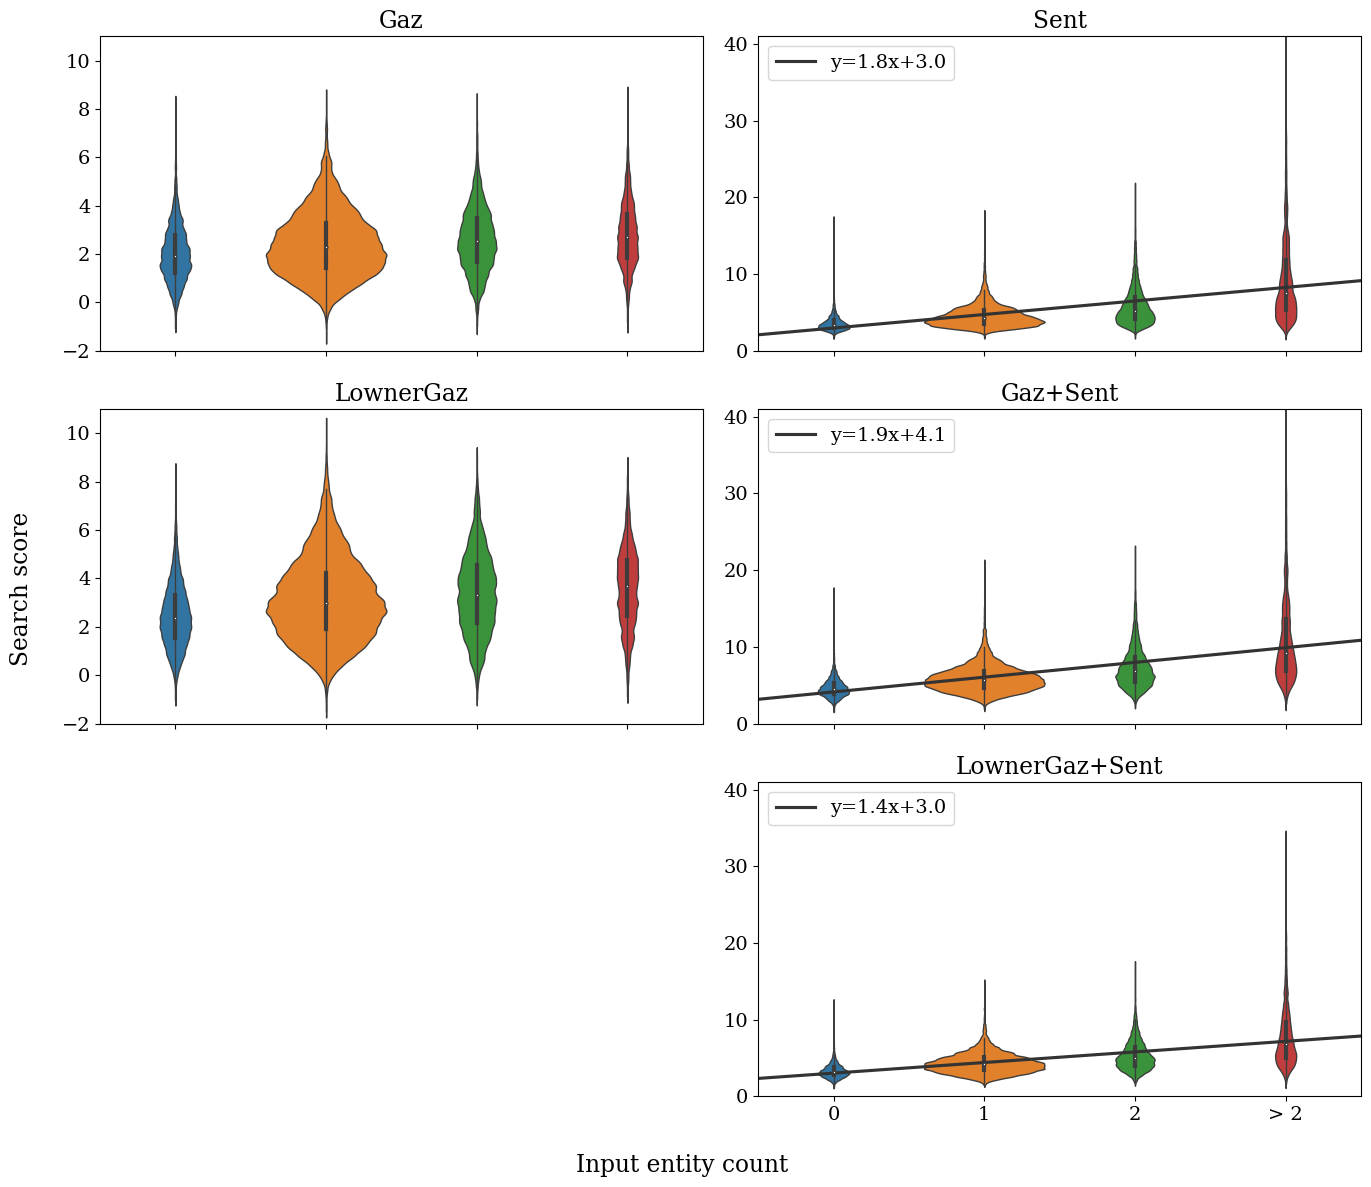

In [45]:
import seaborn as sns
from evaluations.utils import MODEL_ORDER, PLOT_MODEL_NAMES
import matplotlib.pyplot as plt
from scipy import stats

plot_model_names = {
    "t5_asp_gaz": "Gaz",
    "t5_asp_sent": "Sent",
    "t5_asp_lownergaz": "LownerGaz",
    "t5_asp_gaz_sent": "Gaz+Sent",
    "t5_asp_lownergaz_sent": "LownerGaz+Sent",
}
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(14, 12))

fig.supxlabel("Input entity count")
fig.supylabel("Search score")

positions = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 1)
]

axs[(2, 0)].axis('off')

for idx, model in enumerate(sorted(plot_model_names.keys(), key=lambda x: MODEL_ORDER.get(x, 1000))):
    is_left = positions[idx][1] == 0
    if is_left:
        ylimit = (-2, 11)
    else:
        ylimit = (0, 41)
    order = [
        "0",
        "1",
        "2",
        "> 2",
    ]
    sns.violinplot(comp_df.loc[model, "lowner_test"],
                   y="search score",
                   x="target bin",
                   order=order,
                   inner="box",
                   scale="count",
                   bw=0.08,
                   linewidth=1,
                   gridsize=300,
                   split=True,
                   ax=axs[positions[idx]],
                   zorder=1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        comp_df.loc[model, "lowner_test"]['target bin idx'],
        comp_df.loc[model, "lowner_test"]['search score'])
    if r_value >= 0.3 or r_value <= -0.3:
        sns.regplot(
            comp_df.loc[model, "lowner_test"],
            y="search score",
            x="target bin idx",
            #x_bins="target bin",
            order=1,
            scatter=False,
            truncate=False,
            color=".2",
            ax=axs[positions[idx]],
            label="y={0:.1f}x+{1:.1f}".format(slope, intercept))
        axs[positions[idx]].legend(loc=2)
    axs[positions[idx]].set_ylim(ylimit)
    axs[positions[idx]].set_xlabel("")

    axs[positions[idx]].set_ylabel("")
    axs[positions[idx]].set_title(plot_model_names[model])

plt.tight_layout()
LATEX_THESIS_PATH = "/home/loebbert/OneDrive/Studium/Master/Masterarbeit/Thesis"
plt.savefig(os.path.join(LATEX_THESIS_PATH, "drawings", "01_performance", "violin_corr_input_entity_search_score.png"), dpi=200)


## Hypothesis 1-3 - Linechart T5-ASP F1 per seed

In [3]:
from evaluations.performance_01 import get_per_sample_metrics, aggregate_performance_metrics

performance_metrics = get_per_sample_metrics()
agg_perf_metrics = aggregate_performance_metrics(performance_metrics)
agg_perf_metrics.loc[:, :, "last", "lowner_test"]

/home/loebbert/miniconda3/envs/haystack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


fn      fp     tp  precision     recall  \
seed model                                                                     
1    dict_match_gaz               22774   81934  20942  20.356546  47.904657   
     dict_match_gaz_sent          22162   81322  21554  20.951437  49.304602   
     dict_match_lownergaz          7943  264557  35773  11.911231  81.830451   
     dict_match_lownergaz_sent     6513  263601  37203  12.367854  85.101565   
     dict_match_sent              22464   81460  21252  20.690864  48.613780   
     flair_roberta                 6513    7548  37203  83.133338  85.101565   
     search_match_gaz             26851   30203  16865  35.831138  38.578552   
     search_match_gaz_sent        25163   23606  18553  44.007211  42.439839   
     search_match_lownergaz       18824   30498  24892  44.939520  56.940251   
     search_match_lownergaz_sent  17646   17914  26070  59.271553  59.634916   
     search_match_sent            33071    2893  10645  78.630521  24.350352   
     t5_asp                        6977    5354  36739  87.280545  84.040168   
     t5_asp_gaz                    6110    4887  37606  88.499282  86.023424   
     t5_asp_gaz_sent               5360    4561  38356  89.372510  87.739043   
     t5_asp_lownergaz              8906    3713  34810  90.361602  79.627596   
     t5_asp_lownergaz_sent         5007    3949  38709  90.742651  88.546528   
     t5_asp_sent                   6499    4750  37217  88.681583  85.133590   
2    dict_match_gaz               22777   81937  20939  20.353630  47.897795   
     dict_match_gaz_sent          22198   81358  21518  20.916443  49.222253   
     dict_match_lownergaz          7990  264604  35726  11.895582  81.722939   
     dict_match_lownergaz_sent     6475  263563  37241  12.380487  85.188489   
     dict_match_sent              22470   81466  21246  20.685022  48.600055   
     flair_roberta                 6495    7528  37221  83.177278  85.142740   
     search_match_gaz             26847   30199  16869  35.839636  38.587702   
     search_match_gaz_sent        25170   23613  18546  43.990607  42.423827   
     search_match_lownergaz       18800   30474  24916  44.982849  56.995151   
     search_match_lownergaz_sent  17642   17910  26074  59.280648  59.644066   
     search_match_sent            33071    2893  10645  78.630521  24.350352   
     t5_asp                        6956    5504  36760  86.977096  84.088206   
     t5_asp_gaz                    8266    4314  35450  89.150991  81.091591   
     t5_asp_gaz_sent               5480    4409  38236  89.661156  87.464544   
     t5_asp_lownergaz              5527    4023  38189  90.469535  87.357032   
     t5_asp_lownergaz_sent         5206    3737  38510  91.154401  88.091317   
     t5_asp_sent                   6668    4572  37048  89.014897  84.747003   
3    dict_match_gaz               22767   81927  20949  20.363350  47.920670   
     dict_match_gaz_sent          22132   81292  21584  20.980598  49.373227   
     dict_match_lownergaz          8009  264623  35707  11.889255  81.679477   
     dict_match_lownergaz_sent     6475  263563  37241  12.380487  85.188489   
     dict_match_sent              22456   81452  21260  20.698653  48.632080   
     flair_roberta                 6420    7852  37296  82.608310  85.314301   
     search_match_gaz             26835   30187  16881  35.865131  38.615152   
     search_match_gaz_sent        25180   23623  18536  43.966887  42.400952   
     search_match_lownergaz       18838   30512  24878  44.914244  56.908226   
     search_match_lownergaz_sent  17637   17905  26079  59.292015  59.655504   
     search_match_sent            33069    2891  10647  78.645295  24.354927   
     t5_asp                        7009    5636  36707  86.689654  83.966969   
     t5_asp_gaz                    6136    4728  37580  88.824809  85.963949   
     t5_asp_gaz_sent               5631    4426  38085  89.588577  87.119133   
     t5_asp_lownergaz              54

In [21]:
f1_seed_metrics = agg_perf_metrics.loc[:, :, "last", "lowner_test"].reset_index()
t5_f1_seed_metrics = f1_seed_metrics[
    f1_seed_metrics["model"].str.startswith("t5_asp")
    | f1_seed_metrics["model"].str.startswith("flair")]


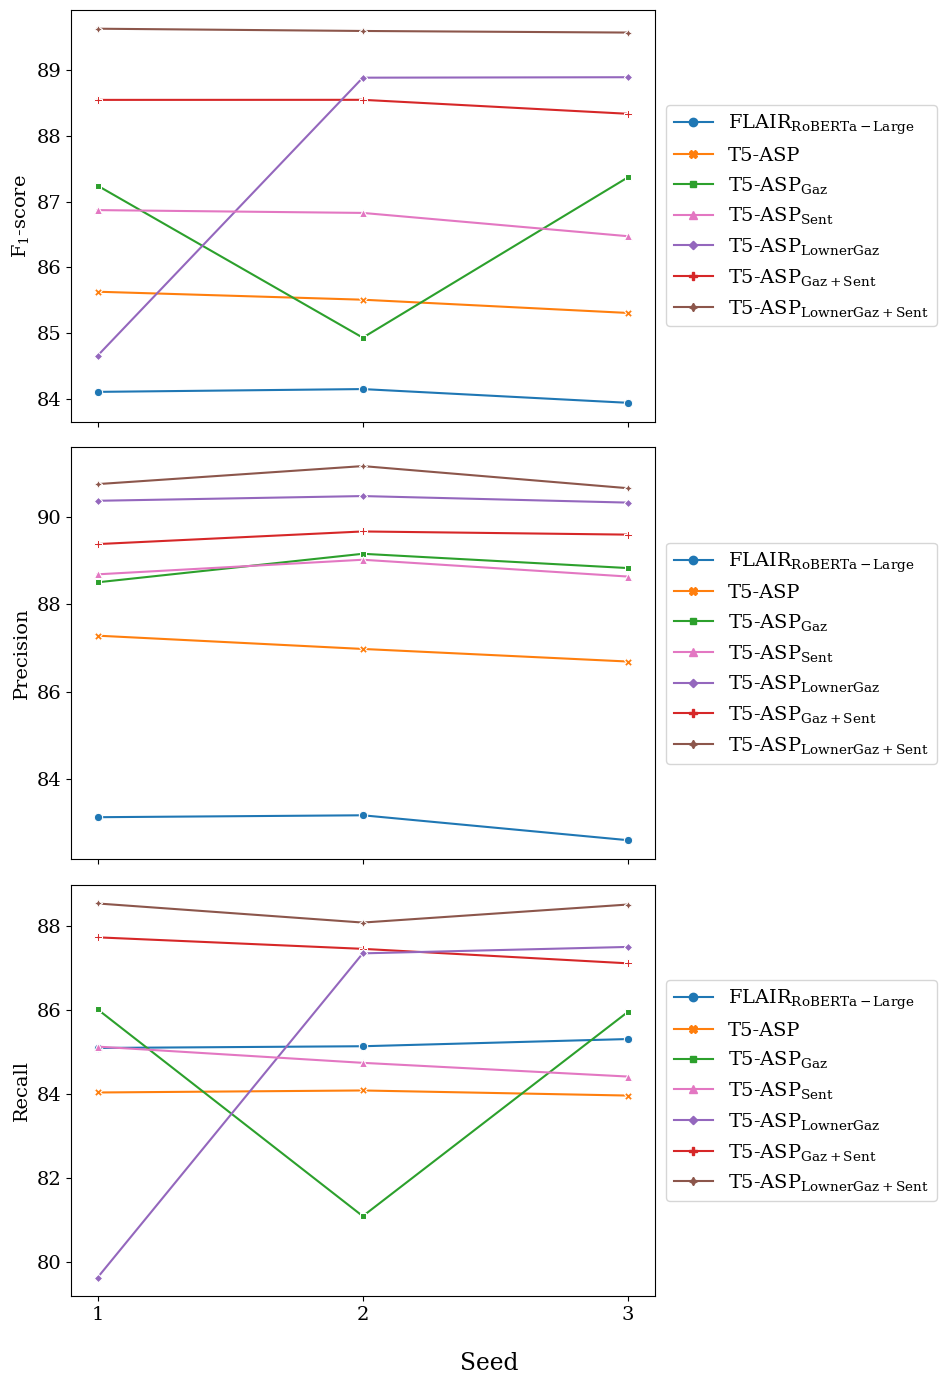

In [22]:
import seaborn as sns
from evaluations.utils import MODEL_ORDER, PLOT_MODEL_NAMES
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,14), layout="tight")
fig.supxlabel("Seed")

sns.lineplot(t5_f1_seed_metrics, x="seed", y="f1", hue="model", style="model", dashes=False, markers=True, ax=axs[0])
handles, labels = axs[0].get_legend_handles_labels()
order = [label_idx for _, label_idx in sorted([(MODEL_ORDER[label], idx) for idx, label in enumerate(labels)])]
axs[0].legend([handles[idx] for idx in order],
              [PLOT_MODEL_NAMES[labels[idx]] for idx in order],
              bbox_to_anchor=(1.5, 0.5),
              loc=7)
axs[0].set_ylabel("$F_{1}$-score")
axs[0].set_xlabel("")

sns.lineplot(t5_f1_seed_metrics,
             x="seed",
             y="precision",
             hue="model",
             style="model",
             dashes=False,
             markers=True,
             ax=axs[1])
handles, labels = axs[1].get_legend_handles_labels()
order = [
    label_idx for _, label_idx in sorted([(MODEL_ORDER[label], idx)
                                          for idx, label in enumerate(labels)])
]
axs[1].legend([handles[idx] for idx in order],
              [PLOT_MODEL_NAMES[labels[idx]] for idx in order],
              bbox_to_anchor=(1.5, 0.5),
              loc=7)
axs[1].set_ylabel("Precision")
axs[1].set_xlabel("")

sns.lineplot(t5_f1_seed_metrics,
             x="seed",
             y="recall",
             hue="model",
             style="model",
             dashes=False,
             markers=True,
             ax=axs[2])
handles, labels = axs[2].get_legend_handles_labels()
order = [
    label_idx for _, label_idx in sorted([(MODEL_ORDER[label], idx)
                                          for idx, label in enumerate(labels)])
]
axs[2].legend([handles[idx] for idx in order],
              [PLOT_MODEL_NAMES[labels[idx]] for idx in order],
              bbox_to_anchor=(1.5, 0.5),
              loc=7)
axs[2].set_ylabel("Recall")
axs[2].set_xlabel("")

LATEX_THESIS_PATH = "/home/loebbert/OneDrive/Studium/Master/Masterarbeit/Thesis"
plt.savefig(os.path.join(LATEX_THESIS_PATH, "drawings", "01_performance",
                         "t5_f1_per_seed.png"),
            bbox_inches="tight",
            dpi=200)
